# Reconstruction demo

An introductory example demonstrating basic reconstruction functionality implemented in `simplecryoem` using the ribosome data in the EMPIAR 10076 dataset. In particular, we show:

1. High-resolution reconstruction using preconditioned SGD.
2. Ab initio reconstruction using MCMC sampling.

In [1]:
from matplotlib import pyplot as plt
import jax.numpy as jnp
from jax import random

from simplecryoem.emfiles import load_data
from simplecryoem.preprocess import preprocess
from simplecryoem.forwardmodel import Slice
from simplecryoem.optimization import Loss, GradV, sgd, get_sgd_vol_ops, precon_sgd
from simplecryoem.utils import mip_x, mip_y, mip_z
from simplecryoem.ab_initio import ab_initio_mcmc

In [2]:
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 6, 6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the data

First, use the `load_data` function to load the particle images from the _mrcs_ file and their parameters from the _star_ file.

In [3]:
# data_dir = "../../../Relion5_SPA_tutorial/"
# star_file = "Refine3D/job029/run_data.star"

In [4]:
data_dir = "../../../Relion_10076/"
star_file = "my_particles.star" 

In [5]:
params0, imgs0 = load_data(data_dir, star_file, load_imgs=True, fourier=False)

print(f"params0 keys: {params0.keys()}")
print(f"imgs0.shape = {imgs0.shape}")

load_data: number of partcles: 50403
load_data: data loaded, time:  159.90 sec.
params0 keys: dict_keys(['ctf_params', 'pixel_size', 'angles', 'shifts'])
imgs0.shape = (50403, 320, 320)


In [6]:
params0

{'ctf_params': array([[ 1.84025000e+04,  1.88770000e+04, -9.93000000e+00, ...,
          2.70000000e+00,  0.00000000e+00,  2.62000000e+00],
        [ 1.84533008e+04,  1.89278008e+04, -9.93000000e+00, ...,
          2.70000000e+00,  0.00000000e+00,  2.62000000e+00],
        [ 1.78185000e+04,  1.82930000e+04, -9.93000000e+00, ...,
          2.70000000e+00,  0.00000000e+00,  2.62000000e+00],
        ...,
        [ 5.24260010e+03,  6.01450000e+03, -5.53100000e+01, ...,
          2.70000000e+00,  0.00000000e+00,  2.62000000e+00],
        [ 5.23800000e+03,  6.00989990e+03, -5.53100000e+01, ...,
          2.70000000e+00,  0.00000000e+00,  2.62000000e+00],
        [ 5.81270020e+03,  6.58470020e+03, -5.53100000e+01, ...,
          2.70000000e+00,  0.00000000e+00,  2.62000000e+00]]),
 'pixel_size': array([1.31, 1.31, 1.31, ..., 1.31, 1.31, 1.31]),
 'angles': array([[ 1.81241735,  2.29342029, -0.98206151],
        [ 0.11070859,  2.71066397, -0.45742968],
        [ 2.58072377,  2.57256945,  1.4181

### Preprocess the data

Some basic preprocessing: compute the Fourier transform of the images and extract the angles, shifts and the CTF parameters from the `params0` dictionary.

In [7]:
N0 = imgs0.shape[0]
nx0 = imgs0.shape[1]

subset_seed = 60
subset_key = random.PRNGKey(subset_seed)
idx_full = random.permutation(subset_key, N0)

print(subset_key)
print(idx_full[:10])

nx_crop = 128 
N = 10000 

idx = idx_full[:N]

processed_data = preprocess(imgs0, params0, nx_crop=nx_crop, idx=idx)

[ 0 60]
[ 9175 46877 21798   708 36704 38339  1744  3155  1960 28282]
imgs0.shape = (50403, 320, 320)
pixel_size0.shape = (50403,)
angles0.shape = (50403, 3)
shifts0.shape = (50403, 2)
ctf_params0.shape = (50403, 9)
N0 = 50403
idx provided
N = 10000
Taking FFT of the images:
Batch 1/10  1.57 sec.
Batch 2/10  1.57 sec.
Batch 3/10  1.56 sec.
Batch 4/10  1.56 sec.
Batch 5/10  1.57 sec.
Batch 6/10  1.57 sec.
Batch 7/10  1.57 sec.
Batch 8/10  1.58 sec.
Batch 9/10  1.56 sec.
Batch 10/10  1.56 sec.
FFT done. Time:  17.42 sec.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 1.28000000e+02]
Vectorised imgs_f.shape = (10000, 16384)
Mask radius = 0.1502862595419847
Noise free, setting sigma_noise = 1


In [8]:
# Images and image-specific parameters
# (orientation angles, in-plane shifts, ctf parameters)
imgs_f = processed_data["imgs_f"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]

# These parameters are the same for all images
pixel_size = processed_data["pixel_size"]
nx = processed_data["nx"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
x_grid = processed_data["x_grid"]
N = imgs_f.shape[0]

Display a projection image.

Text(0.5, 1.0, 'Real space')

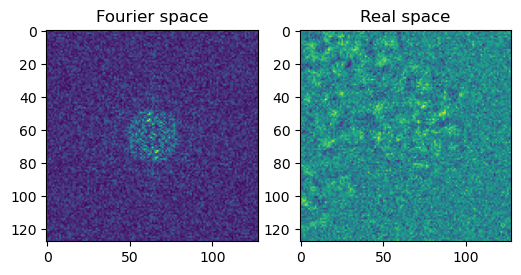

In [9]:
img_index = 102

plt.subplot(121)
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[img_index].reshape([nx, nx]))))
plt.title("Fourier space")

plt.subplot(122)
plt.imshow(
    jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(imgs_f[img_index].reshape([nx, nx]))))
)
plt.title("Real space")

One last preprocessing step is to apply a spherical mask to avoid issues related to rotating voxels from the corners of the 3D grid.

In [10]:
# Use the x=0 slice of the 3D mask output by the preprocess function
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

Dispay the mask and a masked image

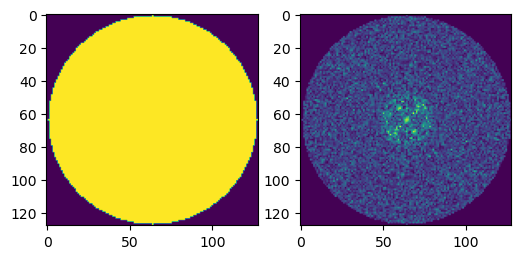

In [11]:
plt.subplot(1, 2, 1)
plt.imshow(jnp.fft.fftshift(mask[0]))

plt.subplot(1, 2, 2)
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[123].reshape([nx, nx]))))

# High-resolution reconstruction

Here we demonstrate high-resolution homogeneous reconstruction using stochastic gradient descent (SGD) with an estimated preconditioner as described in [Toader et al, 2024](https://arxiv.org/abs/2311.16100).

First, we set:
* The egularization parameter $\alpha$ that will be used in the loss function
* The interpolation method: since the forward model involves rotating the input volume (or the coordinates), the rotated volume and the coordinate grid will end up misaligned. We compute the value of the rotated volume at the off-the-grid points using trilinear or nearest-neighbour interpolation.

In [12]:
# Regularization parameter
alpha = 1e-3

# Interpolation method
interp_method = "tri"

Finally, we instantiate the main components of `simplecryoem`, which contain useful compiled and vectorized methods:
* Slice : projection (rotatation, interpolation)
* Loss : the loss function (squared l2 error with an l2 regularization term)
* GradV : the gradient of the loss function

In [13]:
slice_obj = Slice(x_grid, mask=mask, interp_method=interp_method)
loss_obj = Loss(slice_obj, alpha=alpha)
gradv_obj = GradV(loss_obj)

Using these objects, `get_sgd_vol_ops` creates functions that evaluate the loss and the gradient of the loss using minibatches of particle images -- useful for stochastic gradient descent.

In [14]:
# Since jit-compilation benefits from not changing the dimensions of the arrays,
# we will work with the first N=4000 (out of 4452) images so that we can split
# into equal minibatches of 500.
N = imgs_f.shape[0]

grad_func, loss_func, hvp_func, _ = get_sgd_vol_ops(
    gradv_obj, loss_obj, angles[:N], shifts[:N], ctf_params[:N], imgs_f[:N], sigma_noise
)

### Run SGD (no preconditioner)

In [15]:
# Pseudo-random number generator key
key = random.PRNGKey(64)

# Starting point. Make sure dtype=complex!
v0 = jnp.zeros((nx,nx,nx), dtype=jnp.complex64)

In [16]:
N_epochs=30
batch_size = 500
step_size = 1
c = 0.9

In [17]:
v_sgd, loss_sgd, _, _, _ = sgd(
    key,
    grad_func,
    loss_func,
    N,
    v0,
    step_size,
    N_epochs,
    batch_size,
    c=c,
    adaptive_step_size=True,
    verbose=True,
    iter_display=1,
)

Epoch 1/30 

100%|██████████████████████████████████████████| 20/20 [00:10<00:00,  1.83it/s, eta=1.600e+01, grad=1.178e+01, loss=7.724e+08]


  |Grad| = 1.575e+01
  Loss = 7.76862990e+08
  eta = 16.0
  alpha = 1e-10
Epoch 2/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.35it/s, eta=1.600e+01, grad=1.017e+01, loss=7.721e+08]


  |Grad| = 1.053e+01
  Loss = 7.75955053e+08
  eta = 16.0
  alpha = 1e-10
Epoch 3/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.47it/s, eta=1.600e+01, grad=1.184e+01, loss=7.716e+08]


  |Grad| = 1.025e+01
  Loss = 7.75758296e+08
  eta = 16.0
  alpha = 1e-10
Epoch 4/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.31it/s, eta=1.600e+01, grad=1.039e+01, loss=7.693e+08]


  |Grad| = 1.052e+01
  Loss = 7.75724904e+08
  eta = 16.0
  alpha = 1e-10
Epoch 5/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.52it/s, eta=1.600e+01, grad=9.729e+00, loss=7.728e+08]


  |Grad| = 1.017e+01
  Loss = 7.75700196e+08
  eta = 16.0
  alpha = 1e-10
Epoch 6/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.49it/s, eta=1.600e+01, grad=1.159e+01, loss=7.729e+08]


  |Grad| = 1.038e+01
  Loss = 7.75687273e+08
  eta = 16.0
  alpha = 1e-10
Epoch 7/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.53it/s, eta=1.600e+01, grad=1.205e+01, loss=7.715e+08]


  |Grad| = 1.041e+01
  Loss = 7.75693225e+08
  eta = 16.0
  alpha = 1e-10
Epoch 8/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.57it/s, eta=1.600e+01, grad=9.720e+00, loss=7.718e+08]


  |Grad| = 1.031e+01
  Loss = 7.75693852e+08
  eta = 16.0
  alpha = 1e-10
Epoch 9/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.52it/s, eta=1.600e+01, grad=9.397e+00, loss=7.701e+08]


  |Grad| = 1.051e+01
  Loss = 7.75693998e+08
  eta = 16.0
  alpha = 1e-10
Epoch 10/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.49it/s, eta=1.600e+01, grad=9.459e+00, loss=7.700e+08]


  |Grad| = 1.072e+01
  Loss = 7.75696226e+08
  eta = 16.0
  alpha = 1e-10
Epoch 11/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.56it/s, eta=1.600e+01, grad=9.895e+00, loss=7.754e+08]


  |Grad| = 1.023e+01
  Loss = 7.75698233e+08
  eta = 16.0
  alpha = 1e-10
Epoch 12/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.62it/s, eta=1.600e+01, grad=9.099e+00, loss=7.715e+08]


  |Grad| = 1.021e+01
  Loss = 7.75692317e+08
  eta = 16.0
  alpha = 1e-10
Epoch 13/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.54it/s, eta=1.600e+01, grad=1.057e+01, loss=7.722e+08]


  |Grad| = 1.013e+01
  Loss = 7.75678980e+08
  eta = 16.0
  alpha = 1e-10
Epoch 14/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.52it/s, eta=1.600e+01, grad=1.021e+01, loss=7.742e+08]


  |Grad| = 1.039e+01
  Loss = 7.75698464e+08
  eta = 16.0
  alpha = 1e-10
Epoch 15/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.53it/s, eta=1.600e+01, grad=9.519e+00, loss=7.694e+08]


  |Grad| = 1.030e+01
  Loss = 7.75686591e+08
  eta = 16.0
  alpha = 1e-10
Epoch 16/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.53it/s, eta=1.600e+01, grad=9.832e+00, loss=7.716e+08]


  |Grad| = 1.026e+01
  Loss = 7.75701941e+08
  eta = 16.0
  alpha = 1e-10
Epoch 17/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.56it/s, eta=1.600e+01, grad=1.009e+01, loss=7.728e+08]


  |Grad| = 1.046e+01
  Loss = 7.75698214e+08
  eta = 16.0
  alpha = 1e-10
Epoch 18/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.58it/s, eta=1.600e+01, grad=1.059e+01, loss=7.766e+08]


  |Grad| = 1.026e+01
  Loss = 7.75692933e+08
  eta = 16.0
  alpha = 1e-10
Epoch 19/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.62it/s, eta=1.600e+01, grad=9.505e+00, loss=7.723e+08]


  |Grad| = 1.020e+01
  Loss = 7.75694729e+08
  eta = 16.0
  alpha = 1e-10
Epoch 20/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.63it/s, eta=1.600e+01, grad=1.040e+01, loss=7.722e+08]


  |Grad| = 1.037e+01
  Loss = 7.75692844e+08
  eta = 16.0
  alpha = 1e-10
Epoch 21/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.66it/s, eta=1.600e+01, grad=1.114e+01, loss=7.777e+08]


  |Grad| = 1.034e+01
  Loss = 7.75698994e+08
  eta = 16.0
  alpha = 1e-10
Epoch 22/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.61it/s, eta=1.600e+01, grad=1.004e+01, loss=7.711e+08]


  |Grad| = 1.039e+01
  Loss = 7.75698376e+08
  eta = 16.0
  alpha = 1e-10
Epoch 23/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.60it/s, eta=1.600e+01, grad=1.006e+01, loss=7.726e+08]


  |Grad| = 1.018e+01
  Loss = 7.75698560e+08
  eta = 16.0
  alpha = 1e-10
Epoch 24/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.61it/s, eta=1.600e+01, grad=1.060e+01, loss=7.747e+08]


  |Grad| = 1.037e+01
  Loss = 7.75690929e+08
  eta = 16.0
  alpha = 1e-10
Epoch 25/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.56it/s, eta=1.600e+01, grad=9.229e+00, loss=7.751e+08]


  |Grad| = 1.009e+01
  Loss = 7.75692160e+08
  eta = 16.0
  alpha = 1e-10
Epoch 26/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.59it/s, eta=1.600e+01, grad=1.033e+01, loss=7.737e+08]


  |Grad| = 1.019e+01
  Loss = 7.75699608e+08
  eta = 16.0
  alpha = 1e-10
Epoch 27/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.50it/s, eta=1.600e+01, grad=1.020e+01, loss=7.675e+08]


  |Grad| = 1.016e+01
  Loss = 7.75699836e+08
  eta = 16.0
  alpha = 1e-10
Epoch 28/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.58it/s, eta=1.600e+01, grad=9.899e+00, loss=7.756e+08]


  |Grad| = 1.013e+01
  Loss = 7.75702167e+08
  eta = 16.0
  alpha = 1e-10
Epoch 29/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.60it/s, eta=1.600e+01, grad=9.915e+00, loss=7.737e+08]


  |Grad| = 1.018e+01
  Loss = 7.75690892e+08
  eta = 16.0
  alpha = 1e-10
Epoch 30/30 

100%|██████████████████████████████████████████| 20/20 [00:02<00:00,  8.62it/s, eta=1.600e+01, grad=1.017e+01, loss=7.707e+08]


  |Grad| = 1.051e+01
  Loss = 7.75694764e+08
  eta = 16.0
  alpha = 1e-10


The `loss_sgd` variable output by `sgd` is an array containing the value of the loss function at the end of each epoch.

Text(0.5, 1.0, 'Reconstruction loss')

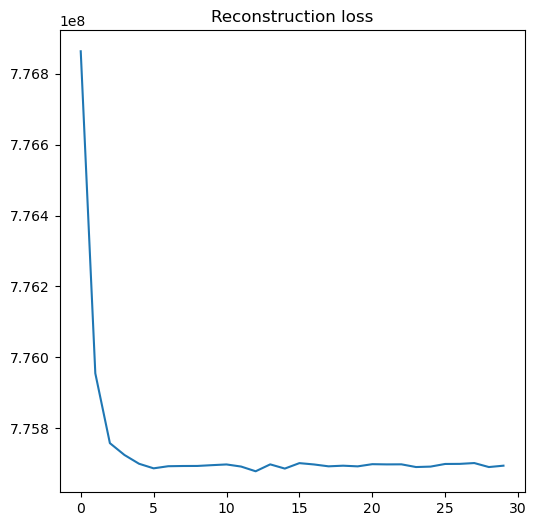

In [18]:
plt.plot(loss_sgd)
plt.title("Reconstruction loss")

And we display the final reconstructed volume (in maximum intensity projection).

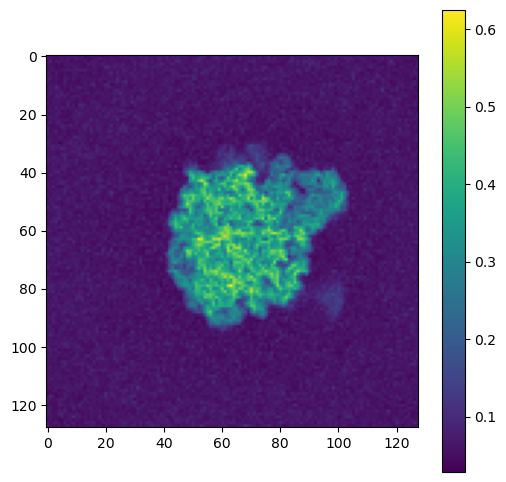

In [19]:
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_sgd)))

mip_z(vr_sgd)
plt.colorbar()

### Preconditioned SGD

We can also run a preconditioned version of the SGD algorithm, which estimates the diagonal of the Hessian matrix of the loss function and uses it as a preconditioner, leading to improved convergence at high resolution.

The diagonal $D$ of the Hessian matrix $H$ is estimated using Hutchinson's diagonal estimator:
$$ D = \mathbb{E}[z \odot Hz] $$
where $z$ is a Rademacher vector (its elements are $+1$ or $-1$ with equal probability) and $\odot$ denotes element-wise multiplication. This computation can be done using minibatches and is efficiently implemented using automatic differentiation in JAX without forming the matrix $H$.

In [20]:
# Initialization of the diagonal
D0 = jnp.ones(v0.shape)

# Parameters specific to preconditioned SGD,
# see the documentation of precon_sgd for details.
beta = 0.2
thresh = 10 # 1e-1

In [21]:
key, key_alg = random.split(key)

v_sgdp, loss_sgdp, _, _ = precon_sgd(
    key,
    loss_func,
    grad_func,
    hvp_func,
    v0,
    step_size,
    D0,
    beta,
    thresh,
    N_epochs,
    batch_size,
    N,
    c=c,
    adaptive_step_size=True,
    iter_display=1,
)

Epoch 1/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.78it/s, eta=3.834e+01, loss=7.878e+08]


  Loss =  7.89079360e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 2/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.78it/s, eta=3.834e+01, loss=7.830e+08]


  Loss =  7.84230754e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 3/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.72it/s, eta=3.834e+01, loss=7.806e+08]


  Loss =  7.81738903e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 4/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.63it/s, eta=3.834e+01, loss=7.813e+08]


  Loss =  7.80251342e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 5/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.80it/s, eta=3.834e+01, loss=7.779e+08]


  Loss =  7.79247924e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 6/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.77it/s, eta=3.834e+01, loss=7.762e+08]


  Loss =  7.78519535e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 7/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.87it/s, eta=3.834e+01, loss=7.791e+08]


  Loss =  7.77980077e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 8/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.94it/s, eta=3.834e+01, loss=7.752e+08]


  Loss =  7.77555661e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 9/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.91it/s, eta=3.834e+01, loss=7.779e+08]


  Loss =  7.77211445e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 10/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.82it/s, eta=3.834e+01, loss=7.747e+08]


  Loss =  7.76930026e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 11/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.97it/s, eta=3.834e+01, loss=7.751e+08]


  Loss =  7.76699988e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 12/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.90it/s, eta=3.834e+01, loss=7.764e+08]


  Loss =  7.76506578e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 13/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.85it/s, eta=3.834e+01, loss=7.752e+08]


  Loss =  7.76341472e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 14/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.96it/s, eta=3.834e+01, loss=7.767e+08]


  Loss =  7.76204873e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 15/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.95it/s, eta=3.834e+01, loss=7.740e+08]


  Loss =  7.76085349e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 16/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.91it/s, eta=3.834e+01, loss=7.726e+08]


  Loss =  7.75984204e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 17/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.91it/s, eta=3.834e+01, loss=7.784e+08]


  Loss =  7.75895274e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 18/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.93it/s, eta=3.834e+01, loss=7.746e+08]


  Loss =  7.75815424e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 19/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.01it/s, eta=3.834e+01, loss=7.739e+08]


  Loss =  7.75749912e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 20/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.99it/s, eta=3.834e+01, loss=7.748e+08]


  Loss =  7.75690922e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 21/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.01it/s, eta=3.834e+01, loss=7.754e+08]


  Loss =  7.75637621e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 22/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.97it/s, eta=3.834e+01, loss=7.732e+08]


  Loss =  7.75591921e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 23/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.00it/s, eta=3.834e+01, loss=7.750e+08]


  Loss =  7.75552202e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 24/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.98it/s, eta=3.834e+01, loss=7.718e+08]


  Loss =  7.75518809e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 25/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.99it/s, eta=3.834e+01, loss=7.690e+08]


  Loss =  7.75487382e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 26/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.06it/s, eta=3.834e+01, loss=7.766e+08]


  Loss =  7.75459467e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 27/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.11it/s, eta=3.834e+01, loss=7.727e+08]


  Loss =  7.75436088e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 28/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.09it/s, eta=3.834e+01, loss=7.770e+08]


  Loss =  7.75414446e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 29/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.05it/s, eta=3.834e+01, loss=7.738e+08]


  Loss =  7.75393089e+08
  eta = 38.33759992447473
  alpha= 10
Epoch 30/30


100%|██████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.09it/s, eta=3.834e+01, loss=7.710e+08]


  Loss =  7.75374273e+08
  eta = 38.33759992447473
  alpha= 10


We see improved convergence of preconditioned SGD.

Text(0.5, 1.0, 'Reconstruction loss')

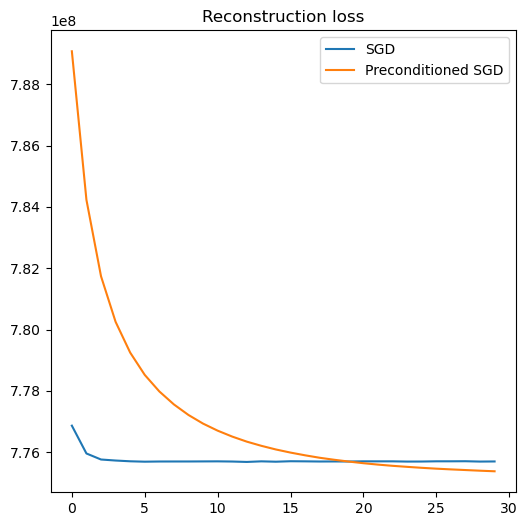

In [26]:
plt.plot(loss_sgd)
plt.plot(loss_sgdp)
plt.legend(["SGD", "Preconditioned SGD"])
plt.title("Reconstruction loss")

And finally display the reconstructed volume using preconditioned SGD.

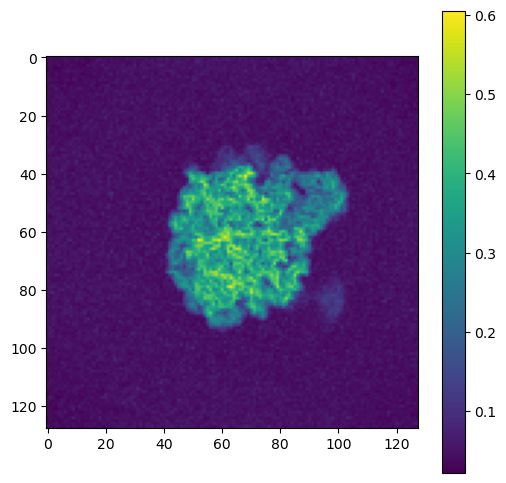

In [27]:
vr_sgdp = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_sgdp)))

mip_z(vr_sgdp)
plt.colorbar()

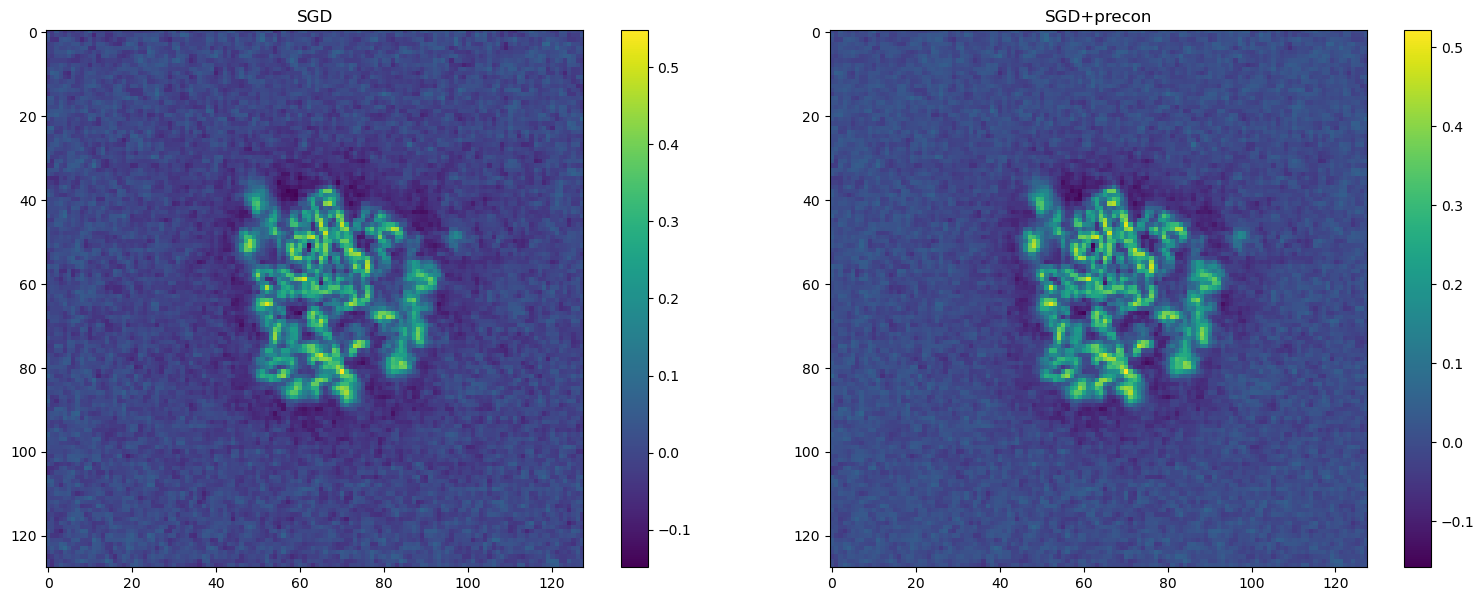

In [28]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
plt.imshow(vr_sgd[:,:,nx//2])
plt.title('SGD')
plt.colorbar()

plt.subplot(122)
plt.imshow(vr_sgdp[:,:,nx//2])
plt.title('SGD+precon')
plt.colorbar()

plt.tight_layout()
plt.show()

# Ab initio reconstruction

This is a demonstration of ab initio reconstruction (i.e. estimating volume, orientations and shifts from scratch) using Markov chain Monte Carlo (MCMC) sampling, based on ideas from [Lederman et al, 2020](https://iopscience.iop.org/article/10.1088/1361-6420/ab5ede/meta).

First, we follow the same pre-processing steps as above to extract 1000 images of 64 x 64 pixels.

[ 0 61]
[31158 50303 61898 58633 58859 59592 11266 13145 20843 65873]
imgs0.shape = (76186, 320, 320)
pixel_size0.shape = (76186,)
angles0.shape = (76186, 3)
shifts0.shape = (76186, 2)
ctf_params0.shape = (76186, 9)
N0 = 76186
idx provided
N = 1000
Taking FFT of the images:
Batch 1/10  0.12 sec.
Batch 2/10  0.12 sec.
Batch 3/10  0.12 sec.
Batch 4/10  0.12 sec.
Batch 5/10  0.12 sec.
Batch 6/10  0.12 sec.
Batch 7/10  0.12 sec.
Batch 8/10  0.12 sec.
Batch 9/10  0.12 sec.
Batch 10/10  0.12 sec.
FFT done. Time:  1.39 sec.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 6.40000000e+01]
Vectorised imgs_f.shape = (1000, 4096)
Mask radius = 0.0739503816793893
Noise free, setting sigma_noise = 1


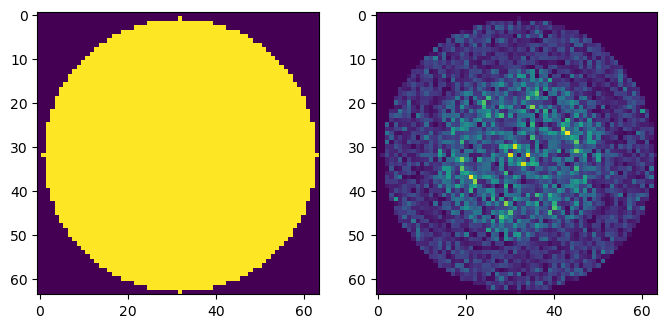

In [99]:
N = 1000
nx_crop = 64 

subset_seed = 61
subset_key = random.PRNGKey(subset_seed)
idx_full = random.permutation(subset_key, N0)

print(subset_key)
print(idx_full[:10])

idx = idx_full[:N]

processed_data = preprocess(imgs0, params0, nx_crop=nx_crop, idx=idx)

imgs_f = processed_data["imgs_f"]
angles_true = processed_data["angles"]
shifts_true = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]

# These parameters are the same for all images
pixel_size = processed_data["pixel_size"]
nx = processed_data["nx"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
x_grid = processed_data["x_grid"]
N = imgs_f.shape[0]

# Use the x=0 slice of the 3D mask output by the preprocess function
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

plt.subplot(1, 2, 1)
plt.imshow(jnp.fft.fftshift(mask[0]))

plt.subplot(1, 2, 2)
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[123].reshape([nx, nx]))))

In [139]:
key = random.PRNGKey(62)

# It will stop when nx_iter=nx anyway, so setting N_iter large enough
N_iter = 200
N_batch = 1

#radius0 = 0.02
#dr = 0.003
#alpha = 1e-7

# Fast option for nx=64
radius0 = 0.02
dr = 0.005
alpha = 1e-2

# Fast options for nx=32
# radius0=0.015
# dr = 0.003
# alpha = 1e-3


sgd_batch_size = 300
learning_rate = 1

vol0 = None
angles0 = None
shifts0 = None

N_samples_vol = 301
N_samples_angles_global = 701
N_samples_angles_local = 301
N_samples_shifts_global = 301
N_samples_shifts_local = 701

imgs_batch = jnp.array(jnp.array_split(imgs_f, N_batch))
ctf_params_batch = jnp.array(jnp.array_split(ctf_params, N_batch))

eps_vol = 2e-5

# HMC params
dt_list = jnp.array([0.1, 0.5, 1, 5])
L = 10

# boundary for sampling shifts in [-B, B]^2
B = pixel_size[0] * nx / 10

out_dir = "../data/ab_initio/"
v_rec, angles_rec, shifts_rec = ab_initio_mcmc(
    key,
    imgs_batch,
    sigma_noise,
    ctf_params_batch,
    x_grid,
    vol0,
    angles0,
    shifts0,
    N_iter,
    learning_rate,
    sgd_batch_size,
    N_samples_vol,
    N_samples_angles_global,
    N_samples_angles_local,
    N_samples_shifts_global,
    N_samples_shifts_local,
    dt_list_hmc=dt_list,
    L_hmc=L,
    radius0=radius0,
    dr = dr,
    alpha=alpha,
    eps_vol=eps_vol,
    B=B,
    B_list=jnp.array([B]),
    freq_marching_step_iters=1,
    interp_method="tri",
    opt_vol_first=True,
    verbose=True,
    save_to_file=False,
)

Fourier radius: 0.07633587786259541
Minibatch factor: None
Starting radius: 0.02
Frequency marching step size: 0.005
Number of frequency marching steps: 12
Number of iterations: 12
B = 8.384
B_list = [8.384]
------------------------------------

Initialitsing volume
Epoch 1/501 

100%|█████████████████| 3/3 [00:05<00:00,  1.82s/it, eta=1.000e+00, grad=2.455e+01, loss=3.237e+08]


  |Grad| = 2.342e+01
  Loss = 3.25630194e+08
  eta = 1
  alpha = 1e-10
Epoch 101/501 

100%|█████████████████| 3/3 [00:00<00:00, 66.51it/s, eta=1.000e+00, grad=8.760e+00, loss=3.217e+08]

  |Grad| = 9.273e+00
  Loss = 3.22178465e+08
  eta = 1
  alpha = 1e-10


Epoch 201/501 

100%|█████████████████| 3/3 [00:00<00:00, 67.39it/s, eta=1.000e+00, grad=9.548e+00, loss=3.214e+08]

  |Grad| = 9.949e+00
  Loss = 3.22179768e+08
  eta = 1
  alpha = 1e-10


Epoch 301/501 

100%|█████████████████| 3/3 [00:00<00:00, 67.11it/s, eta=1.000e+00, grad=9.205e+00, loss=3.251e+08]

  |Grad| = 8.731e+00
  Loss = 3.22180374e+08
  eta = 1
  alpha = 1e-10


Epoch 401/501 

100%|█████████████████| 3/3 [00:00<00:00, 65.40it/s, eta=1.000e+00, grad=9.216e+00, loss=3.215e+08]

  |Grad| = 9.224e+00
  Loss = 3.22176026e+08
  eta = 1
  alpha = 1e-10


Epoch 501/501 

100%|█████████████████| 3/3 [00:00<00:00, 65.65it/s, eta=1.000e+00, grad=9.780e+00, loss=3.192e+08]

  |Grad| = 9.636e+00
  Loss = 3.22174030e+08
  eta = 1
  alpha = 1e-10
Iter 0
nx_iter = 18
Sampling global orientations and shifts


  MCMC sample 100, posterior val = -46193888.99472982
  MCMC sample 200, posterior val = -46164295.59454265
  MCMC sample 300, posterior val = -46141136.140411116
  MCMC sample 400, posterior val = -46124404.30087642
  MCMC sample 500, posterior val = -46110847.69557939
  MCMC sample 600, posterior val = -46098085.60099577
  MCMC sample 700, posterior val = -46088038.47586921
  Time global orientations and shifts sampling = 16.5904803276062
  mean(a_angles_shifts) = nan
Sampling local orientations
  MCMC sample 100, posterior val = -45912313.5785909
  MCMC sample 200, posterior val = -45881630.39146842
  MCMC sample 300, posterior val = -45866939.25592072
  Time local orientations sampling = 2.9375154972076416
  mean(a_angles) = 0.13305883180704284
Sampling local shifts
  MCMC sample 100, posterior val = -45802522.30087631
  MCMC sample 200, posterior val = -45801054.00033783
  MCMC sample 300, posterior val = -45800604.2610858
  MCMC sample 400, posterior val = -45800404.74829067
  MC

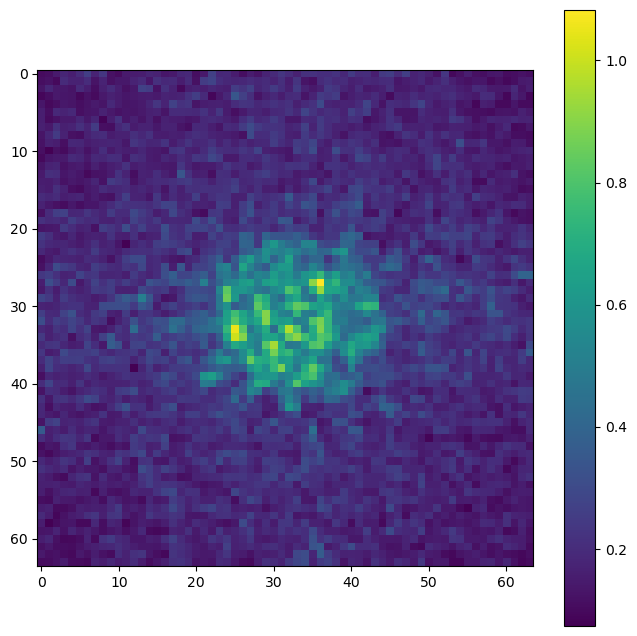

In [145]:
mip_x(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec))))
plt.colorbar()